<a href="https://colab.research.google.com/github/SeaOfFrost/BookCoverClassifier/blob/master/BERT_Cover_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load the Required Folders

In [1]:
ls

drive/  sample_data/


In [2]:
cd drive/My Drive/Book Classifier/book-dataset/Task1/

/content/drive/My Drive/Book Classifier/book-dataset/Task1


## Install required dependencies

In [3]:
!pip install transformers

     |████████████████████████████████| 778kB 7.6MB/s 
     |████████████████████████████████| 890kB 22.6MB/s 
     |████████████████████████████████| 3.0MB 34.0MB/s 
     |████████████████████████████████| 1.1MB 56.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=5caec7a1999982c33669eba743722825ea353c8c26bb4024a953ef946870d1d3
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


# Load Dependencies


In [4]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

# Load the Dataset

In [5]:
df_train = pd.read_csv("train.csv", names = ["ASIN","FILENAME","IMAGE_URL","TITLE","AUTHOR","CATEGORY ID","CATEGORY"], engine = "python")
df_train.head()

,ASIN,FILENAME,IMAGE_URL,TITLE,AUTHOR,CATEGORY ID,CATEGORY
0,1588345297,1588345297.jpg,http://ecx.images-amazon.com/images/I/51l6XIoa...,With Schwarzkopf: Life Lessons of The Bear,Gus Lee,1,Biographies & Memoirs
1,1404803335,1404803335.jpg,http://ecx.images-amazon.com/images/I/51UJnL3T...,"Magnets: Pulling Together, Pushing Apart (Amaz...",Natalie M. Rosinsky,4,Children's Books
2,1446276082,1446276082.jpg,http://ecx.images-amazon.com/images/I/51MGUKhk...,Energy Security (SAGE Library of International...,NaN,10,Engineering & Transportation
3,1491522666,1491522666.jpg,http://ecx.images-amazon.com/images/I/51qKvjsi...,An Amish Gathering: Life in Lancaster County,Beth Wiseman,9,Christian Books & Bibles
4,970096410,0970096410.jpg,http://ecx.images-amazon.com/images/I/51qoUENb...,City of Rocks Idaho: A Climber's Guide (Region...,Dave Bingham,26,Sports & Outdoors


In [6]:
df_train.shape

(51300, 7)

In [55]:
# check class distribution
df_train['CATEGORY ID'].value_counts(normalize = True)

29    0.033333
28    0.033333
1     0.033333
2     0.033333
3     0.033333
4     0.033333
5     0.033333
6     0.033333
7     0.033333
8     0.033333
9     0.033333
10    0.033333
11    0.033333
12    0.033333
13    0.033333
14    0.033333
15    0.033333
16    0.033333
17    0.033333
18    0.033333
19    0.033333
20    0.033333
21    0.033333
22    0.033333
23    0.033333
24    0.033333
25    0.033333
26    0.033333
27    0.033333
0     0.033333
Name: CATEGORY ID, dtype: float64

Split into Train and Validation Set

In [11]:
train_text, valid_text, train_labels, valid_labels = train_test_split(df_train['TITLE'], df_train['CATEGORY ID'], 
                                                                    random_state=2018, 
                                                                    test_size=0.1, 
                                                                    stratify=df_train['CATEGORY ID'])

Load the Test Dataset

In [7]:
df_test = pd.read_csv("test.csv", names = ["ASIN","FILENAME","IMAGE_URL","TITLE","AUTHOR","CATEGORY ID","CATEGORY"], engine = "python")
test_text, test_labels = df_test["TITLE"], df_test["CATEGORY ID"]

# Initialize and Load the Model

Import BERT and Tokenizer

In [8]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [9]:
# sample data
text = ["this is a bert model tutorial", "we will fine-tune a bert model"]

# encode text
sent_id = tokenizer.batch_encode_plus(text, padding=True, return_token_type_ids=False)

# output
print(sent_id)

{'input_ids': [[101, 2023, 2003, 1037, 14324, 2944, 14924, 4818, 102, 0], [101, 2057, 2097, 2986, 1011, 8694, 1037, 14324, 2944, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


Tokenization

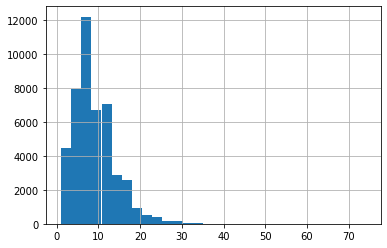

In [12]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]
pd.Series(seq_len).hist(bins = 30)

In [13]:
max_seq_len = 25

In [14]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_valid = tokenizer.batch_encode_plus(
    valid_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

Convert Integer Sequences to Tensors

In [15]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# for validation set
valid_seq = torch.tensor(tokens_valid['input_ids'])
valid_mask = torch.tensor(tokens_valid['attention_mask'])
valid_y = torch.tensor(valid_labels.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

Create Dataloaders 

In [16]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
valid_data = TensorDataset(valid_seq, valid_mask, valid_y)

# sampler for sampling the data during training
valid_sampler = SequentialSampler(valid_data)

# dataLoader for validation set
val_dataloader = DataLoader(valid_data, sampler = valid_sampler, batch_size=batch_size)

Freeze BERT parameters

In [17]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

Define Model

In [18]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      super(BERT_Arch, self).__init__()
      self.bert = bert 
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      # relu activation function
      self.relu =  nn.ReLU()
      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,30)
      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):
      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask)
      x = self.fc1(cls_hs)
      x = self.relu(x)
      x = self.dropout(x)
      # output layer
      x = self.fc2(x)
      # apply softmax activation
      x = self.softmax(x)
      return x

In [20]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)
model = model.cuda()

In [21]:
# optimizer
from transformers import AdamW
optimizer = AdamW(model.parameters(), lr = 1e-3)

Find Class Weights

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
class_wts = compute_class_weight('balanced', np.unique(train_labels), train_labels)
print(class_wts)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]


In [ ]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.cuda()

# loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 50

Fine-Tune BERT 

In [ ]:
def train():
  model.train()
  total_loss, total_accuracy = 0.0, 0.0

  # empty list to save model predictions
  total_preds=[]

  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 100 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.cuda() for r in batch]

    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)

  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [ ]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0.0, 0.0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      # elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.cuda() for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

Start Training

In [ ]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 50
  Batch   100  of  1,443.
  Batch   200  of  1,443.
  Batch   300  of  1,443.
  Batch   400  of  1,443.
  Batch   500  of  1,443.
  Batch   600  of  1,443.
  Batch   700  of  1,443.
  Batch   800  of  1,443.
  Batch   900  of  1,443.
  Batch 1,000  of  1,443.
  Batch 1,100  of  1,443.
  Batch 1,200  of  1,443.
  Batch 1,300  of  1,443.
  Batch 1,400  of  1,443.

Evaluating...
  Batch    50  of    161.
  Batch   100  of    161.
  Batch   150  of    161.

Training Loss: 3.016
Validation Loss: 2.616

 Epoch 2 / 50
  Batch   100  of  1,443.
  Batch   200  of  1,443.
  Batch   300  of  1,443.
  Batch   400  of  1,443.
  Batch   500  of  1,443.
  Batch   600  of  1,443.
  Batch   700  of  1,443.
  Batch   800  of  1,443.
  Batch   900  of  1,443.
  Batch 1,000  of  1,443.
  Batch 1,100  of  1,443.
  Batch 1,200  of  1,443.
  Batch 1,300  of  1,443.
  Batch 1,400  of  1,443.

Evaluating...
  Batch    50  of    161.
  Batch   100  of    161.
  Batch   150  of    161.

Training L

# Testing

Load Best Model

In [22]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

Run for Test Set

In [41]:
from torch import topk

def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [47]:
# get predictions for test data
with torch.no_grad():
  preds = model(test_seq.cuda(), test_mask.cuda())
  pred_data = preds.detach().cpu()
  preds = preds.detach().cpu().numpy()

In [57]:
# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.40      0.25      0.31       190
           1       0.28      0.35      0.31       190
           2       0.41      0.47      0.44       190
           3       0.82      0.88      0.85       190
           4       0.27      0.23      0.25       190
           5       0.59      0.46      0.52       190
           6       0.52      0.59      0.56       190
           7       0.61      0.87      0.72       190
           8       0.39      0.48      0.43       190
           9       0.41      0.44      0.43       190
          10       0.63      0.30      0.41       190
          11       0.46      0.34      0.39       190
          12       0.46      0.51      0.48       190
          13       0.26      0.24      0.25       190
          14       0.53      0.58      0.55       190
          15       0.33      0.29      0.31       190
          16       0.54      0.47      0.50       190
          17       0.46    

In [58]:
top_acc = []
top_acc = accuracy(pred_data, test_y, topk = (1, 3, 5, 30))
print(f"Top 1 Accuracy is: {top_acc[0]}")
print(f"Top 3 Accuracy is: {top_acc[1]}")
print(f"Top 5 Accuracy is: {top_acc[2]}")

Top 1 Accuracy is: 44.98245620727539
Top 3 Accuracy is: 68.19298553466797
Top 5 Accuracy is: 78.49122619628906


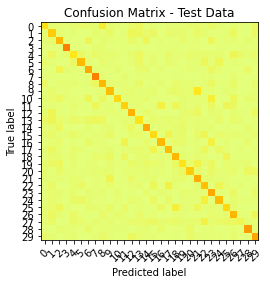

<Figure size 3600x3600 with 0 Axes>

In [59]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt 
cm = confusion_matrix(test_y, preds)
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = [str(i) for i in range(30)]
plt.title('Confusion Matrix - Test Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
plt.figure(figsize = (50, 50))
plt.show()

In [60]:
# confusion matrix
pd.crosstab(test_y, preds)

col_0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
row_0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,48,5,3,2,5,7,6,4,32,6,2,0,6,12,1,3,0,2,3,2,4,7,2,8,2,1,5,1,0,11
1,3,66,3,0,3,0,0,5,2,8,0,2,15,12,6,10,0,6,4,6,1,9,4,1,1,3,11,0,0,9
2,2,5,90,0,0,0,17,1,5,2,1,1,8,3,15,0,2,0,1,6,1,3,0,14,1,3,3,0,4,2
3,0,0,0,167,0,0,0,4,5,1,0,1,0,1,0,0,1,1,1,0,1,1,0,0,1,1,0,1,1,2
4,0,13,1,4,43,10,1,8,4,5,3,0,5,13,1,3,1,8,2,2,7,4,7,4,5,1,16,9,3,7
5,6,3,0,0,10,88,3,0,7,2,1,0,2,11,1,4,0,6,2,0,2,3,14,3,15,1,3,1,0,2
6,0,0,19,4,2,0,113,2,1,1,4,0,0,6,6,0,2,0,0,1,3,1,1,11,3,1,0,0,9,0
7,0,1,0,0,1,0,0,166,4,0,0,4,0,1,1,1,0,0,1,0,0,0,3,2,0,0,4,0,0,1
8,10,0,3,3,4,1,2,13,91,3,2,2,1,8,0,1,4,0,6,3,4,1,2,10,1,1,8,0,0,6
